In [2]:
import sys
sys.path.append('..')
from Common.Dataset_generator import DatasetsNMResidualBlockToOne, DatasetsNMResidual

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

- Critical paramters: 1. horizon and 2. filter
- By using this formulation, one step trajectory split make sense.
- Before adding residual_error signal, it shows weak non-markovianity.
- Add residual_error history, it shows strong non-markovian property.
- hand feature is very hard to find, I found only sin function can improve performance. But increase the horizon is more effective.

In [3]:
horizon = 36     # maximum 70 under this framework, neural networks might be able to fushion longer horizon
dof = 7

In [4]:
D = DatasetsNMResidualBlockToOne('../data/trajectories', horizon, False, False, subsample=1, filter=False)
# path:str, horizon:int, overlapping:bool, shuffle_dataset:bool, subsample: sampling gap, filter: smoothness

<Common.Dataset_generator.DatasetsNMResidualBlockToOne object at 0x7f90843870b8> : no mean-var initialization!


In [5]:
print('Dataset length: ',len(D))
print('State dimension: ', D[1][0].shape) # q_mea (horizon,7), qd_mea, q_ref, qd_ref, qdd_ref
print('Action dimension: ', D[1][1].shape) # residual tau

# q_mean, qd_mea include current state, length = horizon
# q_ref, qd_ref, qdd_ref start from next step, length = horizon

Dataset length:  242621
State dimension:  (36, 21)
Action dimension:  (7,)


In [6]:
def build_dataset_RR(D, horizon, feature=1):
    ''' build a simple block to one dataset
    '''
    datanum = len(D)
    dof = 7
    horizon = D.horizon
    Ytrain = np.zeros([datanum, dof])
    Xtrain = np.zeros([datanum, 21*horizon])
    for i, (state, action) in enumerate(D):
        Ytrain[i, :] = action
        Xtrain[i, :] = state.reshape(-1)
        
    return Ytrain, Xtrain

In [7]:
Ytrain, Xtrain_noExpand = build_dataset_RR(D, horizon)
# build dataset from given datastructure Datasets.

In [8]:
Xtrain_noExpand.shape # without feature trans

(242621, 756)

In [9]:
Ytrain.shape

(242621, 7)

# Training

## Ridge Regression

In [10]:
from regression import CV_RR

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [12]:
def feature(X):
    aug = X
    #aug = np.concatenate([aug, X ** 2], axis=1)
    #aug = np.concatenate([aug, np.cos(0.5*X)], axis=1)
    #aug = np.concatenate([aug, np.sin(X)], axis=1)
    #aug = np.concatenate([aug, np.sin(0.5*X)], axis=1)
    
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

In [13]:
length = Xtrain_noExpand.shape[0]
Xtrain = Xtrain_noExpand.reshape(length, -1)
Xtrain.shape

(242621, 756)

In [14]:
# feature
Xtrain = feature(Xtrain)
Xtrain.shape

(242621, 757)

#### How about PCA? results: not so useful
#### Any hand design feature, worse than the linear ridge regression
#### How about Neural network random feature? results: not so useful
#### Neural network might be better.

100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Min MSE:  1.4515331840571557


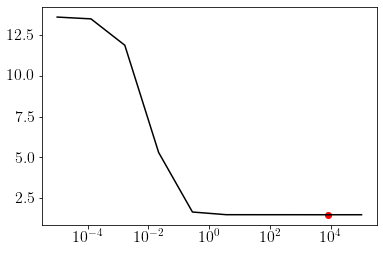

In [15]:
labd = np.logspace(-5,5,10)
RR = CV_RR(labd)
RR.fit(Xtrain, Ytrain, 4)

In [16]:
RR.beta.shape

(757, 7)

In [17]:
U, V, W = np.linalg.svd(RR.beta)
V

array([0.54185737, 0.2545875 , 0.20864917, 0.16129026, 0.14922187,
       0.10834695, 0.04024993])

In [18]:
U, V, W = np.linalg.svd(RR.beta[-7:,:])
V

array([0.02195821, 0.01716276, 0.01486946, 0.00546842, 0.00452357,
       0.00235008, 0.00114416])

In [19]:
np.savetxt('NMF_beta.txt', RR.beta)

### AIC and BIC for ridge regression

In [20]:
Xtrain_noExpand.shape

(242621, 756)

## Neural networks

In [21]:
from DeepNMR.trainAinference import train

### MLP

In [22]:
train(Xtrain_noExpand, Ytrain, model_type='MLP', epoch=300 ,batch_size=128, lr=5e-5)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

### vanilla RNN (Not enough fast)

- Input with dim (256,70,7), output should be (256,70,5) and (2, 256, 5)
- If the RNN with (InputDim=7, hiddenDim=5, layers=2)
- Output should be the total output and output of last step RNN unit

In [ ]:
train(Xtrain_noExpand, Ytrain, model_type='RNN', epoch=100 ,batch_size=128, lr=5e-5, hidden_dim=10, layers=1)

### LSTM (Not enough fast)

In [ ]:
train(Xtrain_noExpand, Ytrain, model_type='LSTM', epoch=200 ,batch_size=64, lr=1e-4, hidden_dim=20, layers=2)

### GRU (Not enough fast)

In [ ]:
train(Xtrain_noExpand, Ytrain, model_type='GRU', epoch=100 ,batch_size=128, lr=5e-5, hidden_dim=7, layers=1)

### 1D CNN ( already the highest accuracy and the only regressor can run in 0.x ms, but still can't beat Ridge Regression)
It regards the (batch, horizon, dof), the dof as the length of image and horizon as image channel

In [ ]:
train(Xtrain_noExpand, Ytrain, model_type='CNN', epoch=200, batch_size=256, lr=5e-5, hidden_dim=50)

## VAR - Vector autoregressive model
Follow this tutorial: [VAR Tutorial](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)

In [23]:
from Common.utils import read_data, numerical_grad_nd, ButterWorthFilter
path = '../data/trajectories/traj3_1.7_z.panda.dat'
dataset = read_data(path)

time = dataset[:,0]

indx = max(np.where(time<40)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra

# get numerical derived qDDot
qDot_real_filtered, _ = ButterWorthFilter(qDot_real, tau_real, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered)

qDotRef_inf = numerical_grad_nd(q_ref)
qDDotRef_inf = numerical_grad_nd(qDotRef_inf)

residual = u_G - tau_real

In [24]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import pandas

In [25]:
# time series
resi_pan = pandas.DataFrame(residual, index=[str(i) for i in range(len(residual))],
                            columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6', 'joint7'])

### Causation using Granger’s Causality Test

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pandas.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '' for var in variables]
    df.index = [var + '' for var in variables]
    return df

grangers_causation_df = grangers_causation_matrix(resi_pan, variables = resi_pan.columns)

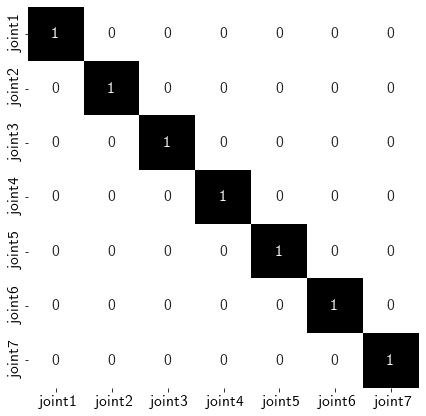

In [27]:
import matplotlib
import seaborn as sns

def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "black"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plt.figure(figsize=[7,7])
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.savefig(path, dpi=200)

save_df_as_image(grangers_causation_df, '/home/jiayun/Desktop/grangers.jpg')

In [28]:
nobs = 40
df_train, df_test = resi_pan[0:-nobs], resi_pan[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(34522, 7)
(40, 7)


### make time series stationary

In [29]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


In [30]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [31]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "joint1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -43.4595
 No. Lags Chosen       = 52
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "joint2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -45.134
 No. Lags Chosen       = 51
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "joint3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [32]:
model = VAR(df_differenced)
AIC = []
BIC = []
for i in np.arange(1,100):
    result = model.fit(i)
    AIC.append(result.aic)
    BIC.append(result.bic)

/home/jiayun/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


AIC say AR oder should be: 61
BIC say AR oder should be: 21


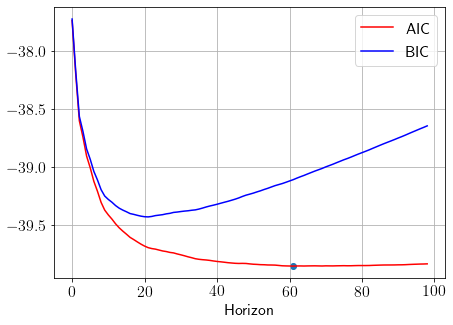

In [77]:
plt.figure(figsize=[7,5])
plt.plot(AIC, '-r', label='AIC')
plt.plot(BIC, '-b', label='BIC')
plt.xlabel('Horizon')
plt.grid()
plt.scatter(np.argmin(AIC), np.min(AIC))
print("AIC say AR oder should be: %i" % np.argmin(AIC))
print("BIC say AR oder should be: %i" % np.argmin(BIC))
plt.legend()
plt.savefig('/home/jiayun/Desktop/AIC_BIC.jpg', dpi=150)
plt.show()

In [34]:
model_fitted = model.fit(61)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Apr, 2022
Time:                     11:37:34
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -39.1212
Nobs:                     34460.0    HQIC:                  -39.6216
Log likelihood:           347433.    FPE:                4.90797e-18
AIC:                     -39.8557    Det(Omega_mle):     4.50170e-18
--------------------------------------------------------------------
Results for equation joint1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000067         0.000408            0.163           0.870
L1.joint1          0.068713         0.005442           12.626           0.000
L1.joint2         -0.007287         0.006339           -1.150          

In [35]:
def invert_transformation(diff_start, forecast):
    """Revert back the differencing to get the forecast to original scale."""
    fc = diff_start + forecast
    return fc

In [ ]:
# save parameters
np.savetxt('Param_NonMarkovianRR.txt',RR.beta)

# start validation

In [45]:
from Common.utils import read_data, numerical_grad_nd, ButterWorthFilter
path = '../data/test_trajectory/traj17_z.panda.dat'
dataset = read_data(path)

time = dataset[:,0]

indx = max(np.where(time<40)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra

# get numerical derived qDDot
qDot_real_filtered, _ = ButterWorthFilter(qDot_real, tau_real, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered)

qDotRef_inf = numerical_grad_nd(q_ref)
qDDotRef_inf = numerical_grad_nd(qDotRef_inf)

residual = u_G[:-1,:] - tau_real[1:,:]
residual = np.concatenate([residual, np.zeros([1,7])])

In [46]:
from Common.utils import friction_dof
parameter = np.load('../Common/fric_param.npy')

In [47]:
length = len(q_real)

In [48]:
target_test = np.concatenate([residual[1:,:], np.zeros([1,7])])

In [49]:
### sigmoidal friction model ###
pred_torque_fc = []
for i in range(length):
    speed = qDot_real_filtered[i]
    tau_fc = friction_dof(parameter, speed)
    pred_torque_fc.append(tau_fc)
    
pred_torque_fc = np.array(pred_torque_fc)
pred_torque_fc = pred_torque_fc.reshape(-1, dof)

MAE = np.abs(pred_torque_fc - target_test).sum() / len(pred_torque_fc)

print('The mean absolute error of fric prediction each step: %.4f' % MAE)

The mean absolute error of fric prediction each step: 2.9856


In [56]:
horizon = 62

In [57]:
### block to one ridge regression ###
import tqdm
pred_torque = []
Xtest = []
VAR_res = []
for i in tqdm.tqdm(range(length)):
    if i < horizon: # if horizon = 1, history contains the current state, residual will be zero
        q_history = np.concatenate([np.zeros([horizon-i-1, dof]), q_real[:i+1, :]])
        qd_history = np.concatenate([np.zeros([horizon-i-1, dof]), qDot_real_filtered[:i+1, :]])
        q_ddot_history = np.concatenate([np.zeros([horizon-i-1, dof]), qDDot_inf[:i+1, :]])
        residual_history = np.concatenate([np.zeros([horizon-i-1, dof]), residual[:i+1, :]])
    else:
        q_history = q_real[i-horizon+1:i+1, :]
        qd_history = qDot_real_filtered[i-horizon+1:i+1, :]
        q_ddot_history = qDDot_inf[i-horizon+1:i+1, :]
        residual_history = residual[i-horizon+1:i+1, :]
    if length - i - 1 < horizon:
        q_refH = np.concatenate([q_ref[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
        qd_ref = np.concatenate([qDotRef_inf[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
        qdd_ref = np.concatenate([qDDotRef_inf[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
    else:
        q_refH = q_ref[i+1:i+1+horizon, :]
        qd_ref = qDotRef_inf[i+1:i+1+horizon, :]
        qdd_ref = qDDotRef_inf[i+1:i+1+horizon, :]
    #####################################   VAR   ######################################
    input_res = np.diff(residual_history, axis=0)
    VAR_res_i = model_fitted.forecast(y=input_res, steps=1)
    fc_i = invert_transformation(residual_history[-1,:].reshape(1,dof), VAR_res_i)
    VAR_res.append(fc_i)
    ###################################################################################
#     X = [q_history, qd_history, q_ddot_history]#, residual_history]
#     X = np.concatenate(X, axis=1)
#     Xtest.append(X)
#     # feature transformation
# Xtest_noExpand = np.array(Xtest)
# Xtest = Xtest_noExpand.reshape(-1, Xtest_noExpand.shape[1]*Xtest_noExpand.shape[2])
# Xtest = feature(Xtest)

# pred_torque_RR = RR.predict(Xtest, RR.beta)

# pred_torque_RR = pred_torque_RR.reshape(-1, dof)

# MAE_RR = np.abs(pred_torque_RR - target_test).sum() / len(pred_torque_RR)
# print('The mean absolute error of ridge regression prediction each step: %.4f' % MAE_RR)

# # 1D CNN validate
# from DeepNMR.trainAinference import inference, load_model
# RNN_model = load_model('/home/jiayun/git/workspace/Regression/DeepNMR/model/LSTM_HR_62_EP_118.pth')
# pred_torque_RNN = inference(RNN_model, Xtest_noExpand)

# ER_RNN = np.abs(pred_torque_RNN - target_test).sum() / len(pred_torque_RNN)
# print('The mean absolute error of MLP prediction each step: %.4f' % ER_RNN)

# # VAR validate
pred_torque_VAR = np.array(VAR_res, dtype=float).reshape(-1, dof)

MAE_VAR = np.abs(pred_torque_VAR - target_test).sum() / len(pred_torque_VAR)
print('The mean absolute error of VAR each step: %.4f' % MAE_VAR)

100%|██████████| 23051/23051 [00:03<00:00, 7533.01it/s]

The mean absolute error of VAR each step: 0.6024


In [58]:
oneStepShift = np.concatenate([np.zeros([1,7]), target_test])
target_test_oneStep = np.concatenate([target_test, np.zeros([1,7])])
MAE_oneStep = np.abs(oneStepShift - target_test_oneStep).sum() / len(oneStepShift)
print('The mean absolute error of one shift prediction each step: %.4f' % MAE_oneStep)

The mean absolute error of one shift prediction each step: 0.7601


### Neural network run on cpu

In [ ]:
import time
start = time.time()
for _ in range(1000):
    RR.predict(Xtest[1,:], RR.beta)
end = time.time()
print("Each inference takes: ", (end-start), "ms")
print("Ridge regression is very fast.")

# TODO 1D CNN speed test
start = time.time()
for _ in range(1000):
    inference(RNN_model, Xtest_noExpand[1:2])
end = time.time()
print("1d-CNN Each inference takes: ", (end-start), "ms")


start = time.time()
for _ in range(1000):
    input_res = np.diff(residual_history, axis=0)
    VAR_res_i = model_fitted.forecast(y=input_res, steps=1)
    fc_i = invert_transformation(residual_history[-1,:].reshape(1,dof), VAR_res_i)
end = time.time()
print("VAR each inference takes: ", (end-start), "ms")

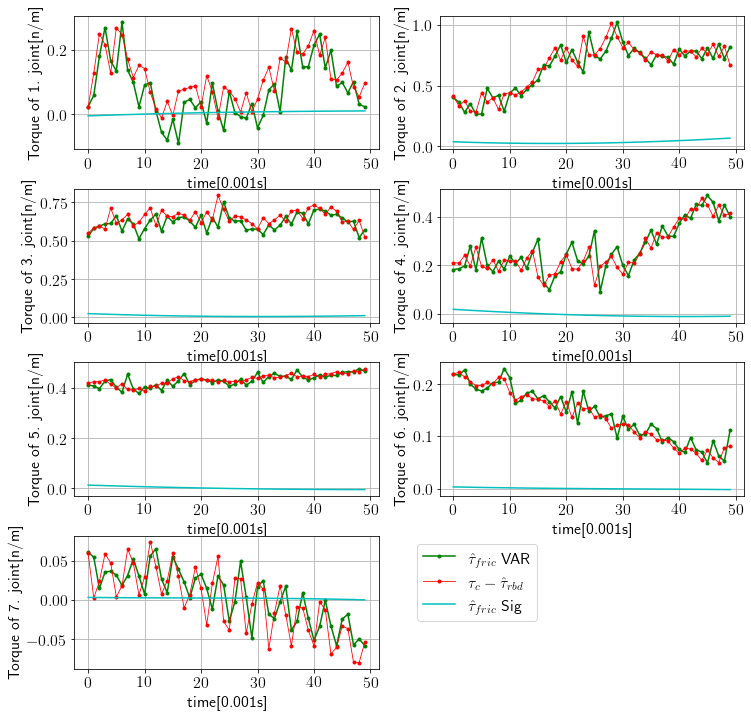

In [80]:
plt.figure(figsize=[12,12])
plt_start = 2020
len_plot = 50
for channel in range(dof):
    plt.subplot(4,2,channel+1,xlabel="time[0.001s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.grid()
#     plt.plot(pred_torque_RNN[:, channel],'-g', label="Res_u_MLP")
#     plt.plot(pred_torque_RR[:, channel],'-b', label="Res_u_RR")
#     plt.plot(target_test[:, channel],'-.r', label="u_measure-u_mcg", linewidth=.8)
#     plt.plot(pred_torque_fc[:, channel],'-c', label="Res_u_sigmoidal", linewidth=1.5)
#     plt.plot(pred_torque_RNN[plt_start:plt_start+len_plot, channel],'.-g', label="Res_u_CNN")
    plt.plot(pred_torque_VAR[plt_start:plt_start+len_plot, channel],'.-g', label=r"$\hat{\tau}_{fric}$ VAR")
#     plt.plot(pred_torque_RR[plt_start:plt_start+len_plot, channel],'.-b', label="Res_u_RR")
    plt.plot(target_test[plt_start:plt_start+len_plot, channel],'.-r', label=r"$\tau_c - \hat{\tau}_{rbd}$", linewidth=.8)
    plt.plot(pred_torque_fc[plt_start:plt_start+len_plot, channel],'-c', label=r"$\hat{\tau}_{fric}$ Sig", linewidth=1.5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)    
plt.legend(bbox_to_anchor=(1.1, 1),fancybox=True)

plt.savefig('/home/jiayun/Desktop/res_plot.jpg', dpi=200)
plt.show()

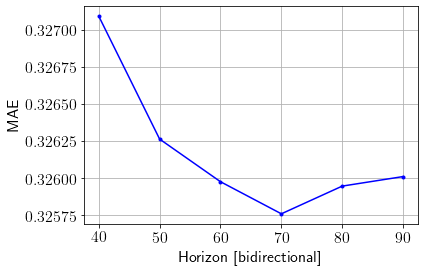

Without residual signal, the most fined tuned RR will reach 2.4, near the performance of sigmoidal emperical model


In [75]:
res_horizon = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
res = [0.45732827194385695, 0.3735931666617142, 0.35778458135120755, 0.3549706396550302, 0.3531611487057511, 0.3503589384000595, 0.3474890465680715, 0.34604512302181406, 0.3441141440098047, 0.34286109476985993, 0.33682135893836, 0.3334348927009534, 0.33035961354447724, 0.32943452757455466, 0.3270925313150056, 0.3262629527203654, 0.3259753456493911, 0.32575885500821267, 0.32594576316356844, 0.32601013975292453, 0.32637973882308186]

plt.plot(res_horizon[14:-1], res[14:-1], '.-b')
plt.grid()
plt.xlabel("Horizon [bidirectional]")
plt.ylabel("MAE")
plt.savefig('/home/jiayun/Desktop/residual_RR.jpg', dpi=200)
plt.show()

print("Without residual signal, the most fined tuned RR will reach 2.4, \
near the performance of sigmoidal emperical model")

In [ ]:
# TODO add section to plot the horizon error

res_RR = [0.4579, 0.3740, 0.3606, 0.3582, 0.3568, 0.3548, 0.3517, 0.3503, 0.3487, 0.3476,
       0.3421, 0.3390, 0.3358, 0.3346, 0.3329, 0.3318, 0.3310, 0.3315, 0.3312]
res_horizon_RR = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 70, 80]
res_horizon_others = [1, 2, 4, 8, 16, 20, 40, 60, 80]
res_MLP = [2.289565052081921, 2.0292190282285762, 1.979354216431684, 1.832023852751012, 1.753465922410528, 1.742425364469071, 1.6835755404901371, 1.7737312386938175, 1.7334700103466862]
res_RNN = [1.8655099618380517, 1.392301171782854, 1.142115036613628, 1.0528797289795013, 1.094722229587519, 1.0521133884597353, 1.097049920777637, 1.087120963632737, 1.124058237084547]
res_LSTM = [2.0501387054446347, 1.5966299470193173, 1.1928966611663812, 1.1570064044045212, 1.1938241313428959, 1.1902276512014849, 1.211238936611169, 1.3090658720135981, 1.2337568563000711]
res_GRU = [1.9725047116479126, 1.3906340961865886, 1.1440795692069141, 1.1253949388057252, 1.0838547438348574, 1.192228478327019, 1.2387572687867892, 1.2038766786391903, 1.212348318991987]
res_CNN = [0.5141258615398829, 0.44938692469744795, 0.4548004509319767, 0.45123211200962837, 0.46636706748884466, 0.48219833383185967, 0.4316032458364025, 0.38975333825959113, 0.5017427045832885]
time_MLP = [0.22159266471862793, 0.22319436073303223, 0.22747802734375, 0.24034833908081055, 0.2568793296813965, 0.2531912326812744, 0.24821901321411133, 0.24407100677490234, 0.24862003326416016]
time_RNN = [0.3820159435272217, 0.48621535301208496, 0.6958022117614746, 1.0900077819824219, 1.895467758178711, 2.29217529296875, 4.106183767318726, 5.791773557662964, 7.640402317047119]
time_LSTM = [0.566260576248169, 0.8372862339019775, 1.3528239727020264, 2.3725414276123047, 4.34888482093811, 5.338448524475098, 10.130519151687622, 14.977542877197266, 20.64245843887329]
time_GRU = [0.5982151031494141, 0.8892858028411865, 1.491605281829834, 2.7067978382110596, 4.7497782707214355, 6.110084533691406, 11.370200634002686, 17.561574935913086, 23.78703784942627]
time_CNN = [0.2529470920562744, 0.2546875476837158, 0.25415802001953125, 0.27920103073120117, 0.25870823860168457, 0.25267577171325684, 0.25829076766967773, 0.2638566493988037, 0.2830851078033447]

plt.figure(figsize=[10,7])
plt.plot(res_horizon_others, np.ones_like(res_horizon_others) * 2.4, '-.b', label='Friction')
plt.plot(res_horizon_others, np.ones_like(res_horizon_others) * 0.455, '-.r', label='Last step')
plt.plot(res_horizon_RR, res_RR, '-b', label='Ridge')
plt.plot(res_horizon_others, res_MLP, label='MLP')
plt.plot(res_horizon_others, res_LSTM, label='LSTM')
plt.plot(res_horizon_others, res_GRU, label='GRU')
plt.plot(res_horizon_others, res_RNN, label='RNN')
plt.plot(res_horizon_others, res_CNN, label='CNN')
plt.grid()
plt.xlabel("Horizon")
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1, 0.9),fancybox=True, ncol=2)
plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=[10,8])
plt.plot(res_horizon_others, np.ones_like(res_horizon_others), '-.c', label='1ms')
plt.plot(res_horizon_others, np.ones_like(res_horizon_others) * 0.01, '-.b', label='Friction')
plt.plot(res_horizon_RR, np.ones_like(res_horizon_RR) * 0.05, '-b', label='Ridge')
plt.plot(res_horizon_others, time_MLP, label='MLP')
plt.plot(res_horizon_others, time_LSTM, label='LSTM')
plt.plot(res_horizon_others, time_GRU, label='GRU')
plt.plot(res_horizon_others, time_RNN, label='RNN')
plt.plot(res_horizon_others, time_CNN, label='CNN')
plt.grid()
plt.xlabel("Horizon")
plt.ylabel("Inference time [ms]")
plt.legend(bbox_to_anchor=(0.2, 1),fancybox=True)
plt.savefig('/home/jiayun/Desktop/time.jpg', dpi=200)
plt.show()

# Statistical significance

In [ ]:
ss_cnn_horizon = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80]
ss_res_CNN_1 = [0.46977687252726064, 0.3918687754082823, 0.3998397712804168, 0.38525937450678316, 0.3830332551914, 0.3703451467582192, 0.3732433265314949, 0.3645096597691683, 0.36351044626157547, 0.3674099678233183]
ss_res_CNN_2 = [0.47748086473283124, 0.3924124654388903, 0.3855474702173004, 0.38240995817014223, 0.3835256543272137, 0.36429440419794085, 0.3694164357476329, 0.36857944384622576, 0.3771935498479798, 0.3677822093209703]
ss_res_CNN_3 = [0.472679943203728, 0.38369150146594294, 0.3830326442511207, 0.37970881404166507, 0.38621218943956215, 0.37213015310052805, 0.37125938445236156, 0.37950829266682845, 0.3670248029594313, 0.3651934880566868]
ss_res_CNN_4 = [0.4688095633677314, 0.38254921548720633, 0.3864095139473298, 0.3846326237264999, 0.37868463992169454, 0.37835034861273487, 0.36403516218423687, 0.37110729412148696, 0.3686714379605776, 0.3609925089638754]

In [ ]:
# RR with CNN
plt.plot(res_horizon, res, '-b', label='Ridge')
plt.plot(ss_cnn_horizon, ss_res_CNN_1, '-r', label='CNN')
plt.plot(ss_cnn_horizon, ss_res_CNN_2, '-r')
plt.plot(ss_cnn_horizon, ss_res_CNN_3, '-r')
plt.plot(ss_cnn_horizon, ss_res_CNN_4, '-r')
plt.scatter(ss_cnn_horizon[np.argmin(ss_res_CNN_1)], np.min(ss_res_CNN_1))
plt.scatter(ss_cnn_horizon[np.argmin(ss_res_CNN_2)], np.min(ss_res_CNN_2))
plt.scatter(ss_cnn_horizon[np.argmin(ss_res_CNN_3)], np.min(ss_res_CNN_3))
plt.scatter(ss_cnn_horizon[np.argmin(ss_res_CNN_4)], np.min(ss_res_CNN_4))
plt.grid()
plt.xlabel("Horizon [bidirectional]")
plt.ylabel("Prediction error N/m")
plt.legend(bbox_to_anchor=(0.7, 1))
plt.savefig('/home/jiayun/Desktop/residual_RR_CNN.jpg', dpi=200)
plt.show()

print("Without residual signal, the most fined tuned RR will reach 2.4, \
near the performance of sigmoidal emperical model")

## Test on 8 figure traj

In [36]:
from Common.utils import read_data, numerical_grad_nd, ButterWorthFilter
path = '../data/8_figure/8figure.dat'
dataset = read_data(path)

time = dataset[:,0]

indx = max(np.where(time<40)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra

# get numerical derived qDDot
qDot_real_filtered, _ = ButterWorthFilter(qDot_real, tau_real, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered)

qDotRef_inf = numerical_grad_nd(q_ref)
qDDotRef_inf = numerical_grad_nd(qDotRef_inf)

residual = u_G[:-1,:] - tau_real[1:, :]
residual = np.concatenate([residual, np.zeros([1,7])])
length = len(q_real)

target_test = residual[1:,:]

In [38]:
### sigmoidal friction model ###
pred_torque_fc = []
for i in range(length):
    speed = qDot_real_filtered[i]
    tau_fc = friction_dof(parameter, speed)
    pred_torque_fc.append(tau_fc)
    
pred_torque_fc = np.array(pred_torque_fc)
pred_torque_fc = pred_torque_fc.reshape(-1, dof)

MAE = np.abs(pred_torque_fc[:-1,:] - target_test).sum() / len(pred_torque_fc)

print('The mean absolute error of fric prediction each step: %.4f' % MAE)

The mean absolute error of fric prediction each step: 1.7363


In [40]:
### block to one ridge regression ###
pred_torque = []
Xtest = []
for i in range(length):
    if i < horizon: # if horizon = 1, history contains the current state, residual will be zero
        q_history = np.concatenate([np.zeros([horizon-i-1, dof]), q_real[:i+1, :]])
        qd_history = np.concatenate([np.zeros([horizon-i-1, dof]), qDot_real_filtered[:i+1, :]])
        residual_history = np.concatenate([np.zeros([horizon-i-1, dof]), residual[:i+1, :]])
    else:
        q_history = q_real[i-horizon+1:i+1, :]
        qd_history = qDot_real_filtered[i-horizon+1:i+1, :]
        residual_history = residual[i-horizon+1:i+1, :]
#     if length - i - 1 < horizon:
#         q_refH = np.concatenate([q_ref[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
#         qd_ref = np.concatenate([qDotRef_inf[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
#         qdd_ref = np.concatenate([qDDotRef_inf[i+1:i+1+horizon, :], np.zeros([horizon - length + i + 1, dof])])
#     else:
#         q_refH = q_ref[i+1:i+1+horizon, :]
#         qd_ref = qDotRef_inf[i+1:i+1+horizon, :]
#         qdd_ref = qDDotRef_inf[i+1:i+1+horizon, :]

    X = [q_history, qd_history, residual_history]#, q_refH, qd_ref, qdd_ref]
    X = np.concatenate(X, axis=1)
    Xtest.append(X)
    # feature transformation
Xtest_noExpand = np.array(Xtest)
Xtest = Xtest_noExpand.reshape(-1, Xtest_noExpand.shape[1]*Xtest_noExpand.shape[2])
Xtest = feature(Xtest)

pred_torque_RR = RR.predict(Xtest, RR.beta)

# manuel defined threshold
idx = np.abs(pred_torque_RR) > 3.
pred_torque_RR[idx] = 0

pred_torque_RR = pred_torque_RR.reshape(-1, dof)

MAE_RR = np.abs(pred_torque_RR[:-1,:] - target_test).sum() / len(pred_torque_RR)
print('The mean absolute error of ridge regression prediction each step: %.4f' % MAE_RR)

# MLP validate
# pred_torque_RNN = inference(RNN_model, Xtest_noExpand)
# MAE_RNN = np.abs(pred_torque_RNN - target_test).sum() / len(pred_torque_RNN)
# print('The mean absolute error of MLP prediction each step: %.4f' % MAE_RNN)

The mean absolute error of ridge regression prediction each step: 0.2677


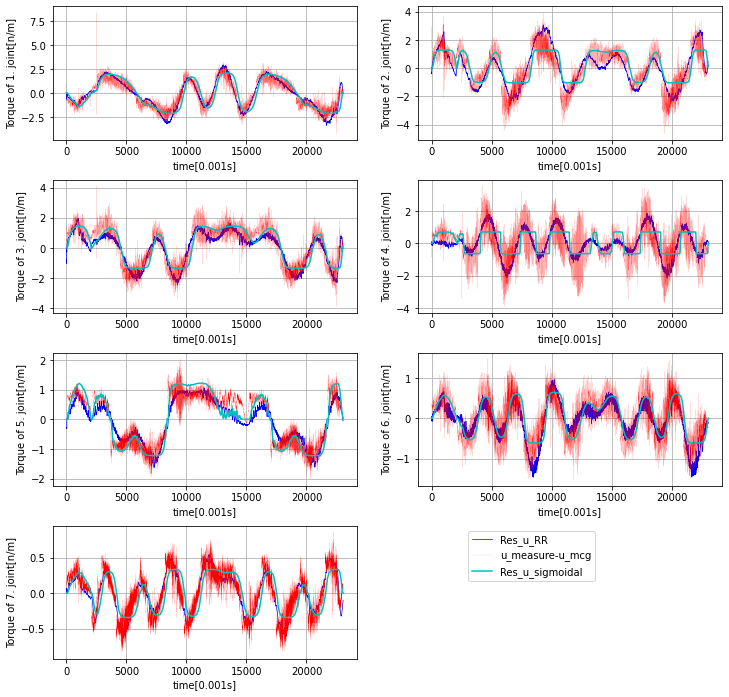

In [28]:
plt.figure(figsize=[12,12])
random_begin = np.random.randint(0, len(pred_torque_RR))
for channel in range(dof):
    plt.subplot(4,2,channel+1,xlabel="time[0.001s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.grid()
    plt.plot(pred_torque_RR[:, channel],'-b', label="Res_u_RR", linewidth=0.7)
    plt.plot(target_test[:, channel],'-.r', label="u_measure-u_mcg", linewidth=0.1)
    plt.plot(pred_torque_fc[:, channel],'-c', label="Res_u_sigmoidal", linewidth=1.5)
#     plt.plot(pred_torque_RNN[:, channel],'-g', label="Res_u_MLP", linewidth=.2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)    
plt.legend(bbox_to_anchor=(1.8, 1),fancybox=True)

plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=200)
plt.show()